# IMDb Sentiment Analysis - Deep Learning Models

In [1]:
# Imports and configurations
import gc
import pandas as pd
import joblib

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import get_scheduler
from tqdm import tqdm
import numpy as np
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    accuracy_score,
    f1_score,
)

import matplotlib.pyplot as plt

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Dataset Preparation

In [2]:
# Load and preprocess the dataset
df = pd.read_csv("../data/raw/IMDB Dataset.csv")

# Remove duplicate reviews to avoid bias
df = df.drop_duplicates()

df["label"] = df["sentiment"].map({"positive": 1, "negative": 0})

In [3]:
# Split the dataset with stratification
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["review"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42,
)

**Why Use Stratified 80:20 Split Instead of K-Fold for Deep Models?**

While **K-Fold Cross-Validation** (especially Stratified K-Fold) provides more robust evaluation, we chose a **stratified 80:20 train-test split** for deep models like LSTM and BERT due to practical constraints:

**1. Time Efficiency**

* Deep models like BERT and LSTM require **significantly longer training times** compared to classical models.
* Performing K-fold would multiply training time by *K* (e.g., 5x longer for 5-fold), which is not feasible within limited development time.

**2. Memory and Hardware Constraints**

* Deep learning models consume large amounts of memory (especially with BERT).
* Running multiple folds in sequence increases risk of **OOM (Out-of-Memory)** errors, especially without GPU or on shared hardware.

**3. Stratified Split Still Preserves Class Distribution**

* We still ensure fair evaluation by using a **stratified split**, so class balance is maintained in both training and test sets.
* This mitigates a key downside of simple random splits and keeps evaluation representative.

**4. Tradeoff for Speed and Comparability**

* Since the same stratified split is used across **all deep models**, it ensures a **fair comparison**.
* This also aligns with the classical models' evaluation strategy, making results easier to interpret.


## Step 2: Tokenization

We use **BERT tokenizer** from HuggingFace Transformers. It performs several tasks:
- **Lowercasing** (for `bert-base-uncased` model)
- **WordPiece tokenization**: breaks words into subword units (e.g. "unbelievable" → "un", "##believable")
- **Padding and truncation** to fit input into fixed size

In [4]:
# Use a pretrained BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(
    train_texts, truncation=True, padding=True, max_length=256
)
val_encodings = tokenizer(
    val_texts, truncation=True, padding=True, max_length=256
)

### Visualization of Tokenization Example

In [5]:
sample = "Unbelievable movie, I loved it!"
tokens = tokenizer.tokenize(sample)
print("Original text:", sample)
print("BERT tokens:", tokens)

Original text: Unbelievable movie, I loved it!
BERT tokens: ['unbelievable', 'movie', ',', 'i', 'loved', 'it', '!']


## Step 3: PyTorch Dataset

In [6]:
class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        }
        item["labels"] = torch.tensor(self.labels[idx])
        return item


# Create datasets
train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)

## Step 4: Simple LSTM Model

LSTM (Long Short-Term Memory) is a type of Recurrent Neural Network (RNN) designed to handle sequence prediction problems and overcome the vanishing gradient issue.

**Key Components:**
- **Embedding Layer:** Converts word indices into dense vectors.
- **LSTM Layer:** Processes sequences with memory cells and gates to capture long-range dependencies.
- **Dropout Layer:** Prevents overfitting.
- **Fully Connected Layer:** Outputs class logits.

**Parameters:**
- `embedding_dim`: Size of the embedding vector.
- `hidden_dim`: Number of features in hidden state.
- `output_dim`: Number of classes.
- `vocab_size`: Number of tokens in the tokenizer vocabulary.

The LSTM uses the final hidden state to make a prediction about sentiment.

In [7]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        _, (hidden, _) = self.lstm(embedded)
        out = self.fc(self.dropout(hidden[-1]))
        return out

In [8]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Parameters for LSTM model
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 2

lstm_model = LSTMClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model.to(device)
lstm_filename = "../models/lstm_model.pt"
try:
    state_dict = joblib.load(lstm_filename)
    lstm_model.load_state_dict(state_dict)
    print(f"Loaded LSTM model state from {lstm_filename}")

except FileNotFoundError:
    # Training LSTM model
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    lstm_model.train()
    for epoch in range(2):
        total_loss = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            outputs = lstm_model(input_ids)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} | Loss: {total_loss / len(train_loader):.4f}")

    # Save LSTM model
    joblib.dump(lstm_model.state_dict(), lstm_filename)

    print(f"Saved LSTM model state to {lstm_filename}")

  0%|          | 0/2480 [00:00<?, ?it/s]

100%|██████████| 2480/2480 [04:26<00:00,  9.31it/s]


Epoch 1 | Loss: 0.6926


100%|██████████| 2480/2480 [02:15<00:00, 18.30it/s]

Epoch 2 | Loss: 0.4971
Saved LSTM model state to ../models/lstm_model.pt


LSTM Classifier Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      4940
           1       0.81      0.90      0.85      4977

    accuracy                           0.84      9917
   macro avg       0.85      0.84      0.84      9917
weighted avg       0.85      0.84      0.84      9917



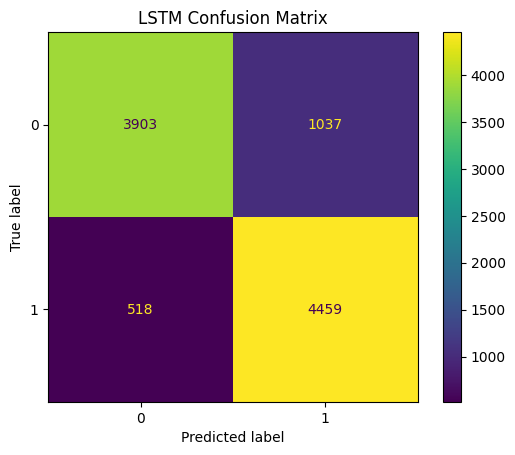

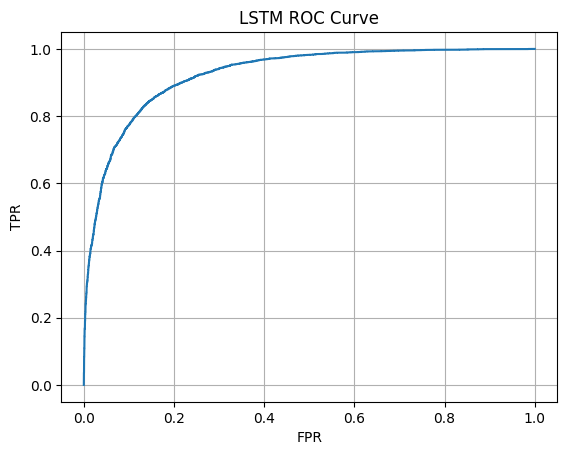

In [9]:
# Evaluate LSTM model
lstm_model.eval()
lstm_preds, lstm_probs, true_labels = [], [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        outputs = lstm_model(input_ids)
        prob = torch.softmax(outputs, dim=1)
        lstm_preds.extend(torch.argmax(outputs, axis=1).cpu().numpy())
        lstm_probs.extend(prob[:, 1].cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("LSTM Classifier Evaluation:")
print(classification_report(true_labels, lstm_preds))
lstm_results = {
    "accuracy": accuracy_score(val_labels, lstm_preds),
    "f1": f1_score(val_labels, lstm_preds, average="macro"),
    "roc_auc": roc_auc_score(val_labels, lstm_probs),
}
ConfusionMatrixDisplay(confusion_matrix(true_labels, lstm_preds)).plot()
plt.title("LSTM Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(true_labels, lstm_probs)
plt.plot(fpr, tpr)
plt.title("LSTM ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.show()

In [10]:
# Clear memory
del lstm_model
del lstm_preds, lstm_probs  # or any large outputs

gc.collect()

8882

## Step 5: Fine-Tuning BERT

BERT (Bidirectional Encoder Representations from Transformers) is a large pre-trained transformer model.
Fine-tuning BERT means adapting it to a specific task (sentiment classification) by training on a labeled dataset.

**Key Concepts:**
- **Tokenizer:** Breaks text into WordPiece tokens.
- **Positional Embeddings:** Added to token embeddings.
- **Transformer Encoder:** Uses self-attention to capture context.
- **Classification Head:** A linear layer on top of BERT's `[CLS]` token output.

**Training Setup:**
- **Optimizer**: `AdamW`, with weight decay. This is standard practice in Hugging Face and modern transformer libraries when fine-tuning large models. This is more proper than Adam because it tends to overfit when fine-tuning large pre-trained models like BERT.
- **Scheduler**: Linear learning rate warm-up and decay. This allows gradients to stabilize, avoiding divergence. Especially for BERT model which usually sensitive to large learning rates at the beginning.
- **Loss**: Cross-entropy for binary classification.

In [14]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

bert_path = "../models/bert_finetuned"
try:
    bert_model = BertForSequenceClassification.from_pretrained(bert_path)
    print(f"Loaded fine-tuned BERT model from {bert_path}")

except Exception:
    bert_model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=2
    )
    bert_model.to(device)

    # Define optimizer and scheduler
    optimizer = torch.optim.AdamW(bert_model.parameters(), lr=5e-5)
    total_steps = len(train_loader) * 2
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps,
    )

    # Fine-tune BERT
    bert_model.train()
    for epoch in range(2):
        total_loss = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = bert_model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
        print(
            f"Epoch {epoch+1} | BERT Loss: {total_loss / len(train_loader):.4f}"
        )

    # Save BERT model
    bert_model.save_pretrained(bert_path)
    tokenizer.save_pretrained(bert_path)

    print(f"Saved fine-tuned BERT model to {bert_path}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 2480/2480 [5:49:15<00:00,  8.45s/it]   


Epoch 1 | BERT Loss: 0.2551


100%|██████████| 2480/2480 [6:11:38<00:00,  8.99s/it]   


Epoch 2 | BERT Loss: 0.1021
Saved fine-tuned BERT model to ../models/bert_finetuned


BERT Evaluation:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      4940
           1       0.92      0.93      0.93      4977

    accuracy                           0.93      9917
   macro avg       0.93      0.93      0.93      9917
weighted avg       0.93      0.93      0.93      9917



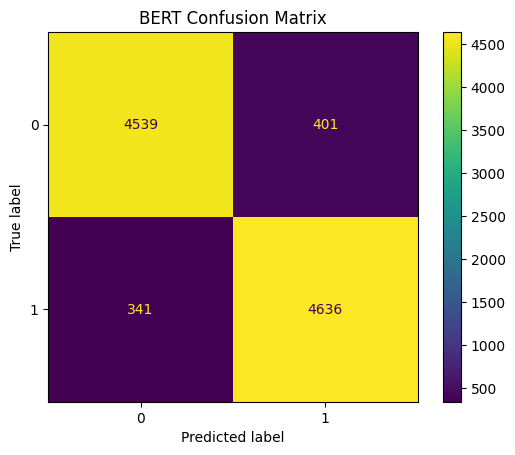

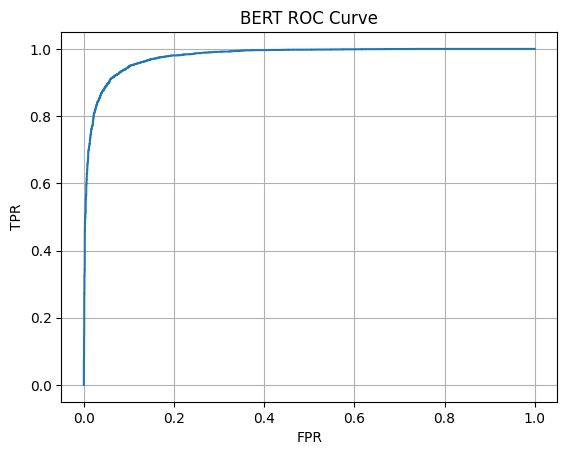

In [15]:
# Evaluate BERT
bert_model.eval()
bert_preds, bert_probs, true_labels = [], [], []
with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = bert_model(**batch)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        bert_preds.extend(preds.cpu().numpy())
        bert_probs.extend(probs[:, 1].cpu().numpy())
        true_labels.extend(batch["labels"].cpu().numpy())

print("BERT Evaluation:")
print(classification_report(true_labels, bert_preds))
bert_results = {
    "accuracy": accuracy_score(val_labels, bert_preds),
    "f1": f1_score(val_labels, bert_preds, average="macro"),
    "roc_auc": roc_auc_score(val_labels, bert_probs),
}
ConfusionMatrixDisplay(confusion_matrix(true_labels, bert_preds)).plot()
plt.title("BERT Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(true_labels, bert_probs)
plt.plot(fpr, tpr)
plt.title("BERT ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.show()

From the outputted **confusion matrices** and **ROC curves**, we can make a detailed comparison between the **LSTM** and **BERT** models.

**ROC Curve** reflects the trade-off between **True Positive Rate (TPR)** and **False Positive Rate (FPR)** at various thresholds.

**LSTM ROC Curve**

* The ROC curve is modest, indicating **medium discriminative power**.
* Appears to be **curved but not steep**, implying **average performance**.

**BERT ROC Curve**

* The ROC curve is very close to the top-left corner — indicating **high sensitivity and specificity**.
* **Steep curve**, suggesting **excellent classification performance**.

**BERT's ROC curve shows near-optimal performance**, whereas LSTM's curve indicates a relatively weaker model.

**Conclusion**

The **BERT model clearly outperforms the LSTM** model in classifying IMDB sentiment reviews — both in terms of confusion matrix statistics (accuracy, precision, recall) and the ROC curve (discriminative ability). BERT's contextual understanding and attention mechanism give it a substantial edge over LSTM's sequential modeling.

If we want high accuracy and robust generalization, **BERT is the better choice**. LSTM can still be viable for lightweight or real-time applications with limited resources.

In [17]:
# Clear memory
del bert_model
del bert_preds, bert_probs  # or any large outputs

gc.collect()

11427

## Comparison of Models

To compare the models, we include both classical and deep learning approaches:

- **Logistic Regression (TF-IDF):** Serves as a traditional baseline using sparse lexical features.
- **LSTM:** Learns sequential patterns in word embeddings.
- **BERT Fine-Tuned:** End-to-end fine-tuned transformer model for classification.

**Evaluation Metrics**

* **Accuracy** gives an overall view but can be misleading in imbalanced datasets.
* **Macro F1-score** balances precision and recall across both classes, and avoids being overly optimistic in class-imbalanced or skewed predictions. Since we care about both false positives and false negatives in sentiment classification, this is a safer metric.
* **ROC AUC** measures ability to rank positive over negative, important when thresholds vary.

In [18]:
# Combine results
eval_df = pd.read_csv("../models/eval_classical.csv", index_col=0)
eval_deep_df = pd.DataFrame(
    {
        "Model": ["LSTM", "BERT"],
        "Accuracy": [lstm_results["accuracy"], bert_results["accuracy"]],
        "F1 Score": [lstm_results["f1"], bert_results["f1"]],
        "ROC AUC": [lstm_results["roc_auc"], bert_results["roc_auc"]],
    }
)

eval_df = pd.concat([eval_df, eval_deep_df])
eval_df.to_csv("../models/eval_deep.csv")

print(eval_df)

                Model  Accuracy  F1 Score   ROC AUC
0  LogisticRegression  0.890222  0.890191  0.956986
1       MultinomialNB  0.856137  0.856133  0.931443
2           LinearSVC  0.879896  0.879883  0.951241
0                LSTM  0.843199  0.842704  0.925476
1                BERT  0.925179  0.925172  0.978568


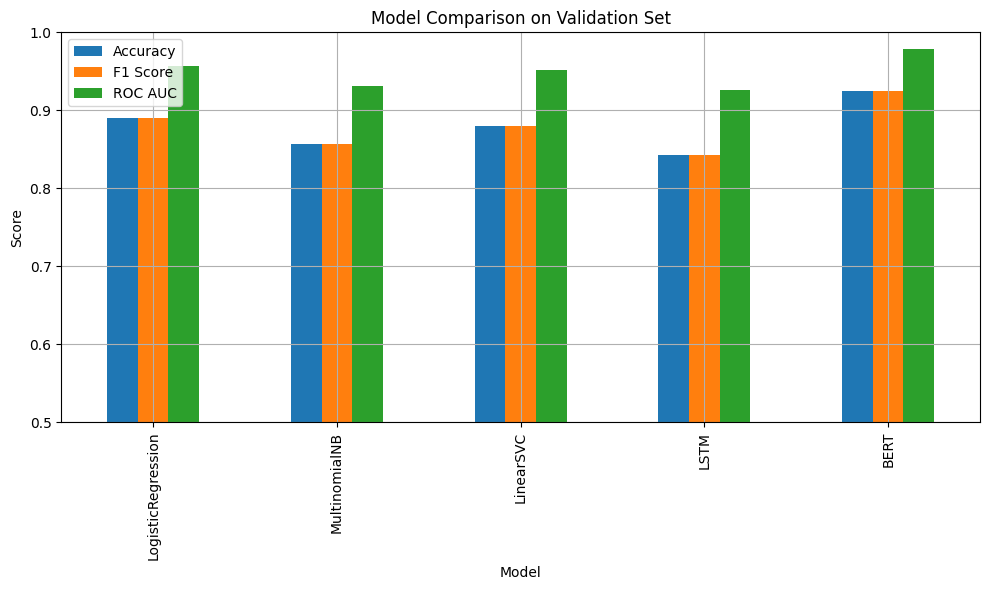

In [19]:
# Visualize comparison
eval_df.set_index("Model")[["Accuracy", "F1 Score", "ROC AUC"]].plot(
    kind="bar", figsize=(10, 6)
)
plt.title("Model Comparison on Validation Set")
plt.ylabel("Score")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()


**1. BERT Significantly Outperforms All Other Models**

* BERT achieves the **highest scores across all metrics**, particularly with:

  * **ROC AUC of 0.9785**: excellent separability between classes.
  * **F1 Score of 0.9251**: very strong balance between precision and recall.
* This confirms that **contextualized word embeddings** from a pre-trained language model are highly effective for sentiment classification tasks.

**2. Logistic Regression Performs Surprisingly Well**

* Despite its simplicity, Logistic Regression (with TF-IDF features) delivers competitive results:

  * **Accuracy 89.1%**, close to BERT.
  * **ROC AUC 0.9569**, indicating strong classification boundary.
* This validates that **bag-of-words approaches with robust preprocessing** can still yield high performance on structured sentiment data like IMDB.

**3. LSTM Underperforms Compared to Expectations**

* The LSTM model lags behind significantly:

  * Only **84.2% F1 Score**, **0.9254 ROC AUC**
* Possible reasons:

  * Model capacity or architecture might not have been optimal.
  * LSTM requires more careful tuning and longer training time.
  * Lacks the deep contextual understanding of BERT.

**4. Classical Models Are a Strong Baseline**

* LinearSVC and Naive Bayes also performed well, both **above 85% accuracy**.
* These models are much faster to train and require less compute, making them great **production candidates** when resources are limited.

**Conclusion**

* **BERT** is the most effective model, ideal for production **if resources allow**.
* **Logistic Regression** is the best trade-off for **speed vs. performance**.
* **LSTM** needs further tuning or larger capacity to be competitive.
* Classical models remain **relevant and reliable baselines** for sentiment tasks.
